In [2]:
# Statistical Analysis of Daily Step Counts
# Comparing step patterns between Alex and Lindsay using rolling averages

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
import numpy as np
import random
from scipy.stats import shapiro, norm, ttest_1samp, kstest, ks_2samp, wilcoxon, mannwhitneyu

# Set random state for reproducibility
RANDOM_STATE = 42
SAMPLE_SIZE = 500
ROLLING_WINDOW = 3  # 3 day blocks

In [ ]:
# Load step data for both individuals
ao = pd.read_csv("alex_steps_per_day.csv")
lg = pd.read_csv("lindsay_steps_per_day.csv")

def apply_date_range(df, yr1, yr2):
    """Filter dataframe to specified date range"""
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    df = df[df['date'] >= datetime(yr1,1,1)]
    df = df[df['date'] < datetime(yr2,1,1)]
    return df

# Filter to 2024-2025 data
ao = apply_date_range(ao, 2024, 2026)
lg = apply_date_range(lg, 2024, 2026)

print(f"Alex data: {len(ao)} days")
print(f"Lindsay data: {len(lg)} days")

len(ao), len(lg)

Alex data: 655 days
Lindsay data: 670 days


(655, 670)

In [4]:
# Create rolling averages to smooth daily variations
def sample_blocks(df, L, sample_size):
    """Calculate L-day rolling average of steps"""
    blocks = []
    for i in range(len(df)-L):
        blocks.append(df['steps'].iloc[i:i+L].tolist())
    # print(blocks[:10])
    return np.array(random.choices(blocks, k=sample_size)).flatten()
# Generate 1000 3-day moving averages blocks and bootstrap sample
aobl = sample_blocks(ao, ROLLING_WINDOW, SAMPLE_SIZE)
lgbl = sample_blocks(lg, ROLLING_WINDOW, SAMPLE_SIZE)

print(f"Alex rolling avg range: {aobl.min():.0f} - {aobl.max():.0f} steps")
print(f"Lindsay rolling avg range: {lgbl.min():.0f} - {lgbl.max():.0f} steps")

Alex rolling avg range: 137 - 26337 steps
Lindsay rolling avg range: 384 - 46745 steps


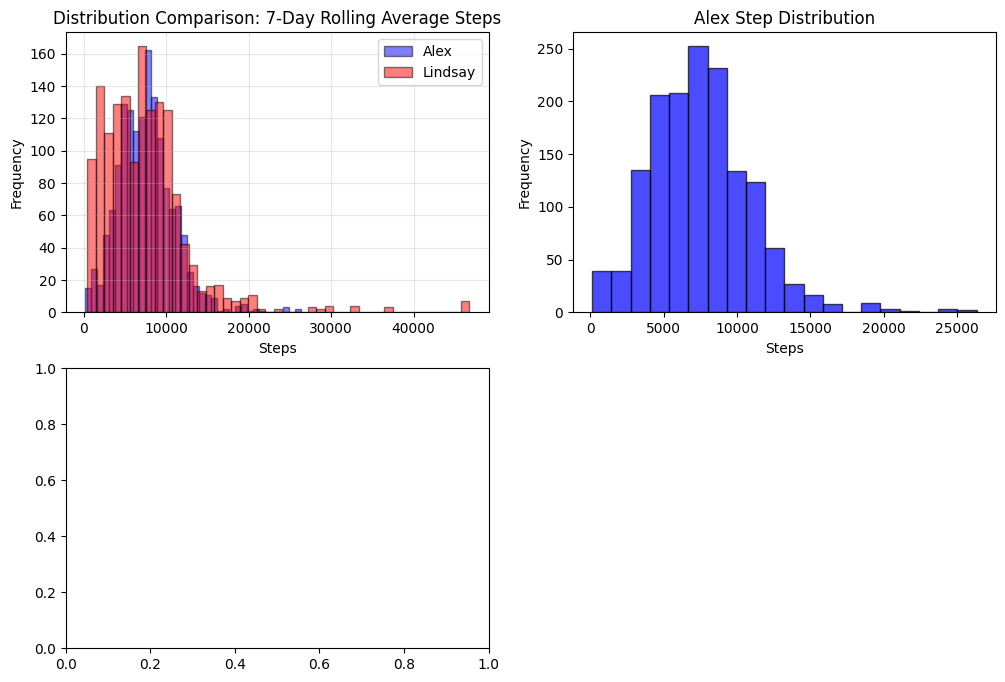

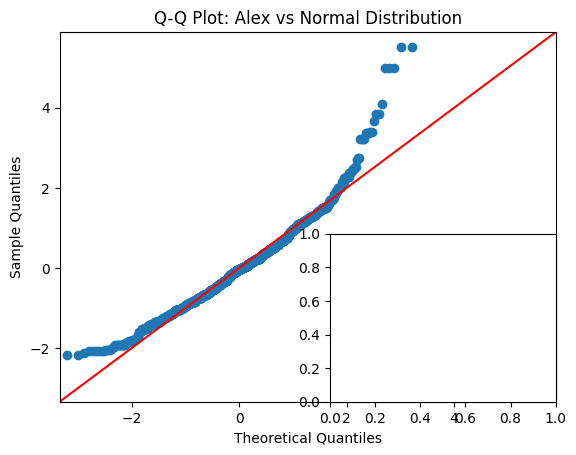

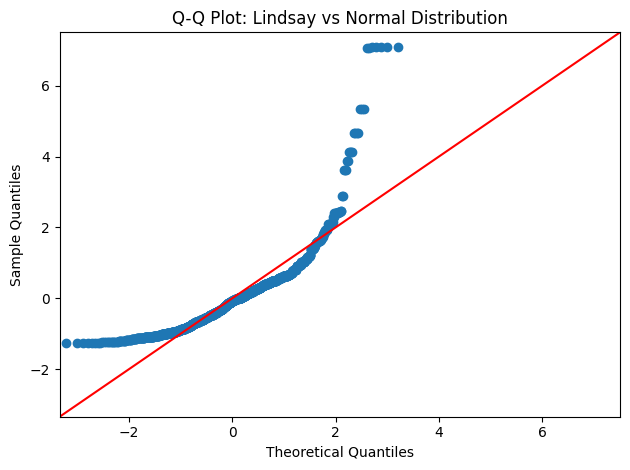

In [ ]:
# Compare distributions with overlaid histograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(aobl, bins='auto', alpha=0.5, label="Alex", color='blue', edgecolor='black')
plt.hist(lgbl, bins='auto', alpha=0.5, label="Lindsay", color='red', edgecolor='black')
plt.title('Distribution Comparison: 7-Day Rolling Average Steps')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(aobl, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Alex Step Distribution')
plt.xlabel('Steps')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sm.qqplot(aobl, line="45", fit=True)
plt.title('Q-Q Plot: Alex vs Normal Distribution')

plt.subplot(2, 2, 4)
sm.qqplot(lgbl, line="45", fit=True)
plt.title('Q-Q Plot: Lindsay vs Normal Distribution')

plt.tight_layout()
plt.show()

In [23]:
# Test for normality using Shapiro-Wilk test
alex_shapiro = shapiro(aobl)
lindsay_shapiro = shapiro(lgbl)

print("NORMALITY TESTING")
print(f"Alex Shapiro-Wilk: statistic={alex_shapiro.statistic:.4f}, p-value={alex_shapiro.pvalue:.2e}")
print(f"Lindsay Shapiro-Wilk: statistic={lindsay_shapiro.statistic:.4f}, p-value={lindsay_shapiro.pvalue:.2e}")
print("\nConclusion: Both distributions are significantly non-normal (p < 0.05)")


NORMALITY TESTING
Alex Shapiro-Wilk: statistic=0.9421, p-value=8.88e-24
Lindsay Shapiro-Wilk: statistic=0.9128, p-value=1.61e-28

Conclusion: Both distributions are significantly non-normal (p < 0.05)


In [ ]:
# Power analysis: 
cohensd = (aobl.mean() - lgbl.mean()) / np.append(aobl,lgbl).std()
cohensd
print(f"Cohen's d: {cohensd:.4f}")
# Cohen's D = 0.1047, pretty small

Cohen's d: 0.1047


In [ ]:
# Function build using Claude Sonnet 4 from the WindSurf Application
# Using your existing bootstrapped samples to find KS confidence intervals
def bootstrap_ks_from_existing_samples(sample1, sample2, n_resamples=1000, alpha=0.05):
    """
    Calculate KS confidence intervals using existing bootstrapped samples.
    
    Parameters:
    -----------
    sample1, sample2 : array-like (your aobl, lgbl)
        Already bootstrapped samples
    n_resamples : int
        Number of bootstrap resamples to generate
    alpha : float
        Significance level (0.05 for 95% CI)
    
    Returns:
    --------
    dict with confidence interval results
    """
    n1, n2 = len(sample1), len(sample2)
    bootstrap_ks_stats = []
    
    # Original KS statistic from your bootstrapped samples
    original_ks, original_p = ks_2samp(sample1, sample2)
    
    # Bootstrap resampling from your existing samples
    for i in range(n_resamples):
        # Resample with replacement from your existing bootstrapped data
        boot_sample1 = np.random.choice(sample1, size=n1, replace=True)
        boot_sample2 = np.random.choice(sample2, size=n2, replace=True)
        
        # Calculate KS statistic for this bootstrap sample
        ks_stat, _ = ks_2samp(boot_sample1, boot_sample2)
        bootstrap_ks_stats.append(ks_stat)

    
    bootstrap_ks_stats = np.array(bootstrap_ks_stats)
    
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_ks_stats, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_ks_stats, 100 * (1 - alpha / 2))
    
    results = {
        'original_ks': original_ks,
        'original_p': original_p,
        'bootstrap_ks_stats': bootstrap_ks_stats,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'confidence_level': 100 * (1 - alpha),
        'mean_bootstrap_ks': np.mean(bootstrap_ks_stats),
        'std_bootstrap_ks': np.std(bootstrap_ks_stats)
    }
    
    return results

# Apply to your existing data
ks_results = bootstrap_ks_from_existing_samples(aobl, lgbl, n_resamples=1000, alpha=0.05)

print("BOOTSTRAP CONFIDENCE INTERVALS FOR KS STATISTIC")
print("=" * 50)
print(f"Original KS statistic: {ks_results['original_ks']:.4f}")
print(f"Original p-value: {ks_results['original_p']:.2e}")
print(f"")
print(f"Bootstrap Results ({ks_results['confidence_level']:.0f}% Confidence Interval):")
print(f"  Mean bootstrap KS: {ks_results['mean_bootstrap_ks']:.4f}")
print(f"  Std bootstrap KS: {ks_results['std_bootstrap_ks']:.4f}")
print(f"  CI Lower bound: {ks_results['ci_lower']:.4f}")
print(f"  CI Upper bound: {ks_results['ci_upper']:.4f}")
print(f"")

# Check if original KS falls within CI
if ks_results['ci_lower'] <= ks_results['original_ks'] <= ks_results['ci_upper']:
    print("✓ Original KS statistic falls within the bootstrap confidence interval")
else:
    print("✗ Original KS statistic falls outside the bootstrap confidence interval")

BOOTSTRAP CONFIDENCE INTERVALS FOR KS STATISTIC
Original KS statistic: 0.1567
Original p-value: 1.78e-16

Bootstrap Results (95% Confidence Interval):
  Mean bootstrap KS: 0.1593
  Std bootstrap KS: 0.0137
  CI Lower bound: 0.1326
  CI Upper bound: 0.1873

✓ Original KS statistic falls within the bootstrap confidence interval


In [ ]:
# Kolmogorov-Smirnov two-sample test
ks_stat, ks_pvalue = ks_2samp(aobl, lgbl)

# Effect size (Cohen's d)
pooled_std = np.append(aobl, lgbl).std()
cohens_d = (aobl.mean() - lgbl.mean()) / pooled_std

print("DISTRIBUTION COMPARISON")
print(f"Alex mean: {aobl.mean():.1f} steps")
print(f"Lindsay mean: {lgbl.mean():.1f} steps")
print(f"Difference: {aobl.mean() - lgbl.mean():.1f} steps")
print(f"\nKolmogorov-Smirnov test: D={ks_stat:.3f}, p-value={ks_pvalue:.2e}")
print(f"Cohen's d (effect size): {cohens_d:.3f} (small effect)")

DISTRIBUTION COMPARISON
Alex mean: 7545.7 steps
Lindsay mean: 7115.9 steps
Difference: 429.8 steps

Kolmogorov-Smirnov test: D=0.157, p-value=1.78e-16
Cohen's d (effect size): 0.105 (small effect)


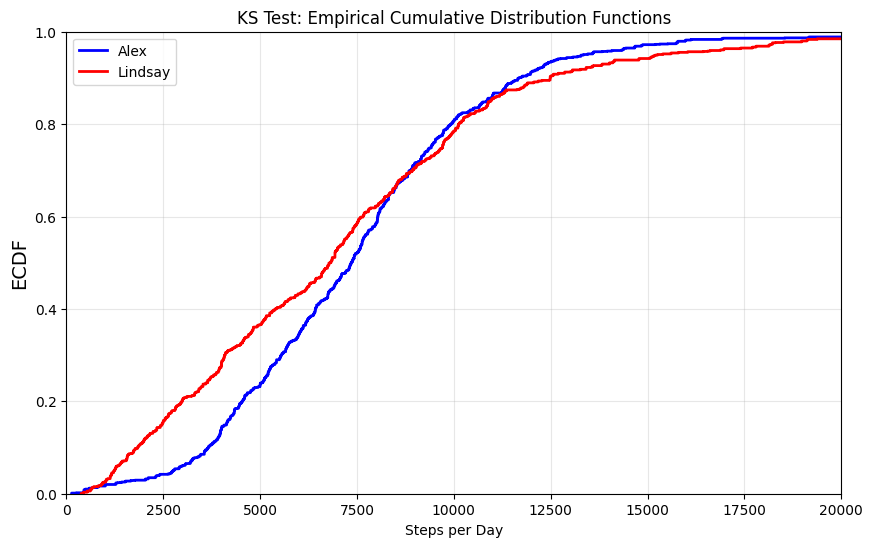

Maximum difference between ECDFs: 0.157


In [29]:
# Visualize empirical cumulative distribution functions
plt.figure(figsize=(10, 6))
plt.ecdf(aobl, label="Alex", color='blue', linewidth=2)
plt.ecdf(lgbl, label="Lindsay", color='red', linewidth=2)
plt.title('KS Test: Empirical Cumulative Distribution Functions')
plt.xlabel('Steps per Day')
plt.ylabel('ECDF', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0,20000)
plt.show()

print(f"Maximum difference between ECDFs: {ks_stat:.3f}")

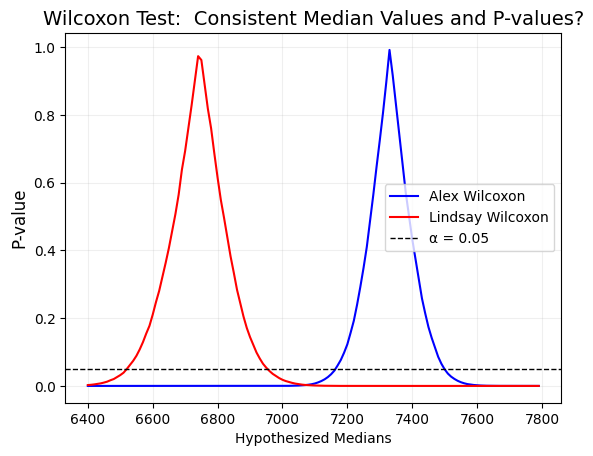

In [ ]:
# Wilcoxon Test experiment
ran = range(6400, 7800,10)
ao_wilcox = [wilcoxon(aobl - tgt).pvalue for tgt in ran]
lg_wilcox =[wilcoxon(lgbl - tgt).pvalue for tgt in ran]

plt.plot(ran, ao_wilcox, color="blue", label = "Alex Wilcoxon")
plt.plot(ran, lg_wilcox, color="red", label = "Lindsay Wilcoxon")
plt.axhline(y=0.05, color='black', linestyle='--', linewidth=1, label='α = 0.05')

plt.legend()
plt.title("Wilcoxon Test:  Consistent Median Values and P-values?", fontsize=14)

plt.xlabel("Hypothesized Medians")
plt.ylabel("P-value", fontsize=12)
plt.grid(True, alpha=0.2)

plt.ylabel
plt.show()

In [105]:
mannwhitneyu(aobl,lgbl)

MannwhitneyuResult(statistic=np.float64(1233835.0), pvalue=np.float64(4.4728902945163425e-06))